In [85]:
import os
import datetime
import dateutil
import tarfile
import requests
import pandas as pd
import pandas.io.sql as sqlio

%matplotlib inline

In [86]:
df = pd.read_pickle('../boursorama/2019/compA 2019-03-15 15:02:01.466949.bz2')
df.head(10)

,last,volume,symbol,name
symbol,,,,
1rPABBV,58.01,0,1rPABBV,ABBVIE
1rPAC,37.69,579750,1rPAC,ACCOR
1rPACNV,46.02,0,1rPACNV,ACCOR
1rPADP,177.1,34850,1rPADP,ADP
1rPAF,10.745,876485,1rPAF,AIR FRANCE - KLM
1rPAI,113.3,1065930,1rPAI,AIR LIQUIDE
1rPAIR,118.26,1517829,1rPAIR,AIRBUS
1rPAKA,60.7,7197,1rPAKA,AKKA TECHNOLOGIES
1rPALUNV,3.46,0,1rPALUNV,ALCATEL I15


In [87]:
df

,last,volume,symbol,name
symbol,,,,
1rPABBV,58.01,0,1rPABBV,ABBVIE
1rPAC,37.69,579750,1rPAC,ACCOR
1rPACNV,46.02,0,1rPACNV,ACCOR
1rPADP,177.1,34850,1rPADP,ADP
1rPAF,10.745,876485,1rPAF,AIR FRANCE - KLM
...,...,...,...,...
1rPWLN,49.96,22164,1rPWLN,WORLDLINE
1rPWLNNV,0.0,0,1rPWLNNV,WORLDLINE
1rPXPO,296.0,0,1rPXPO,XPO LOGISTICS


In [88]:
'''import glob

def collecte_df(directory_path: str = "../boursorama/2019/", market_name: str = "compA") -> pd.DataFrame:
    dfglob = glob.glob1(directory_path, market_name + "*")
    dfs = [pd.read_pickle(directory_path + file) for file in dfglob]
    df = pd.concat(dfs, keys=[file.split()[1] + " " + file.split()[2].split(".bz2")[0] for file in dfglob])
    df.index = pd.to_datetime(df.index.get_level_values(0))
    df = df.rename(columns={'datetime': 'date'})
    return df

'''

import glob
def collecte_df(directory_path:str="../boursorama/2019/", market_name:str="compA") ->pd.DataFrame:
    dfglob = glob.glob1(directory_path, market_name + "*")
    files_path = [directory_path + file for file in dfglob]
    df = pd.concat({dateutil.parser.parse(f.split(market_name)[1].split(".bz2")[0]):pd.read_pickle(f) for f in files_path})
    return df
def convertion(x):
    try:
        
        return float(x)
    except:
        return float(x.replace(' ',''))

def firstFiltering(df, year:str = "2019"):
    df["last"] = [str(x).split("(c)")[0] for x in df["last"]]
    df["last"] = [str(x).split("(s)")[0] for x in df["last"]]
    df['last'] = df['last'].apply(convertion)
    # on retire l'index qui commence par les noms d'entreprises pour finir par leur symbole
    df = df.reset_index(level=1, drop=True)
    df = df.dropna()
    # on nome l'index des date puis on passe la colonne des symboles en index
    df = df.rename_axis('date', axis=0)
    # on retire les jours de congés dont les données ne devraient pas exister
    df.sort_index(inplace=True)
    day_off = [year+'-01-01', year+'-03-30', year+'-04-02', year+'-05-01', year+'-12-25', year+'-12-26']
    for d in day_off:
        if d in df.index:
            df.drop(df.loc[d].index, inplace=True )
    # on passe la colonne des symboles en index et on la met en premier
    #df = df.set_index('symbol', append=True)
    #df = df.swaplevel(0,1).sort_index()
    return df
    

In [89]:
compA = collecte_df(market_name="compA")
compA = firstFiltering(compA, year="2019")

In [90]:
compA

,last,volume,symbol,name
date,,,,
2019-01-02 09:05:02.495959,31.800,0,1rASGO,SAINT-GOBAIN
2019-01-02 09:05:02.495959,135.400,0,1rAURW,UNIB-RODAM-WES STPL
2019-01-02 09:05:02.495959,190.000,0,1rAUL,UNIBAIL-RODAMCO
2019-01-02 09:05:02.495959,12.305,0,FF11_ENGI,ENGIE
2019-01-02 09:05:02.495959,54.100,0,FF11_ENX,EURONEXT
...,...,...,...,...
2019-12-31 17:52:01.811795,0.000,0,1rPFR0012022721,GLE DS 2018 TEST
2019-12-31 17:52:01.811795,15.510,502334,1rPGET,GETLINK (ex: EUROTUNNEL)
2019-12-31 17:52:01.811795,9.845,2662,1rPGNE,GENERAL ELECTRIC


In [91]:
compA.dtypes


last      float64
volume      int64
symbol     object
name       object
dtype: object

In [92]:
import numpy as np
axa = compA[compA["name"] == "AXA"]
axa

,last,volume,symbol,name
date,,,,
2019-01-02 09:05:02.495959,18.858,0,1rPCS,AXA
2019-01-02 09:15:02.257640,18.554,376557,1rPCS,AXA
2019-01-02 09:25:02.791377,18.494,518948,1rPCS,AXA
2019-01-02 09:35:02.419187,18.482,754820,1rPCS,AXA
2019-01-02 09:45:02.823637,18.488,1086243,1rPCS,AXA
...,...,...,...,...
2019-12-31 17:32:01.678859,25.110,1311260,1rPCS,AXA
2019-12-31 17:42:01.814583,25.110,1311260,1rPCS,AXA
2019-12-31 17:42:01.814583,22.190,0,1rPCSNV,AXA


In [93]:
#just pour check s'il y a des valeurs non numériques
before_filtre = axa.copy()
before_filtre['last'] = before_filtre['last'].astype(str)
anything_but_nmbr = before_filtre[before_filtre['last'].str.contains('[^0-9.]')]
print("volume somme: ", anything_but_nmbr['volume'].sum())
anything_but_nmbr

volume somme:  0


,last,volume,symbol,name
date,,,,


In [94]:
axa

,last,volume,symbol,name
date,,,,
2019-01-02 09:05:02.495959,18.858,0,1rPCS,AXA
2019-01-02 09:15:02.257640,18.554,376557,1rPCS,AXA
2019-01-02 09:25:02.791377,18.494,518948,1rPCS,AXA
2019-01-02 09:35:02.419187,18.482,754820,1rPCS,AXA
2019-01-02 09:45:02.823637,18.488,1086243,1rPCS,AXA
...,...,...,...,...
2019-12-31 17:32:01.678859,25.110,1311260,1rPCS,AXA
2019-12-31 17:42:01.814583,25.110,1311260,1rPCS,AXA
2019-12-31 17:42:01.814583,22.190,0,1rPCSNV,AXA


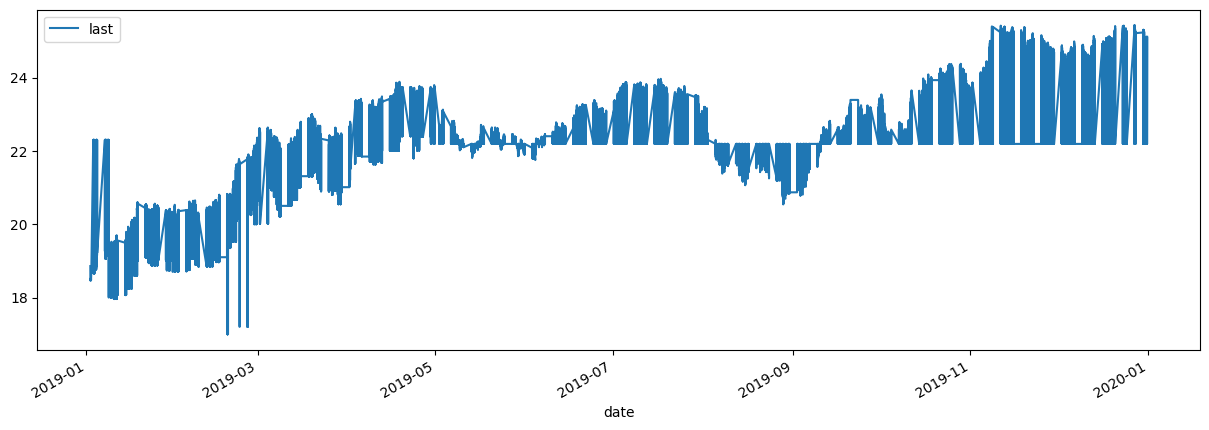

In [95]:
import matplotlib.pyplot as plt


axa.plot( y='last', figsize=(15, 5))
plt.show()



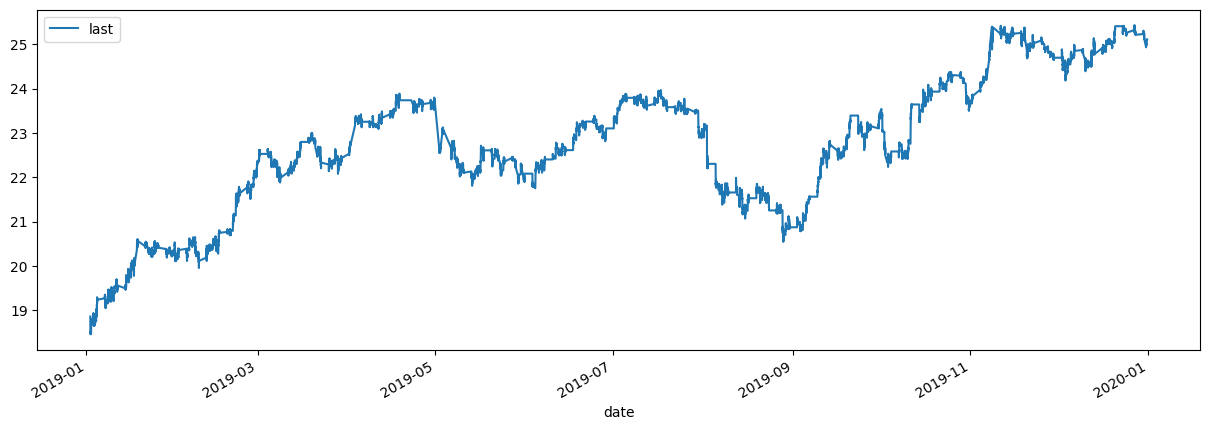

In [96]:
axa_1rPCS = axa[axa['symbol'] == '1rPCS']

axa_1rPCS.plot( y='last', figsize=(15, 5))
plt.show()

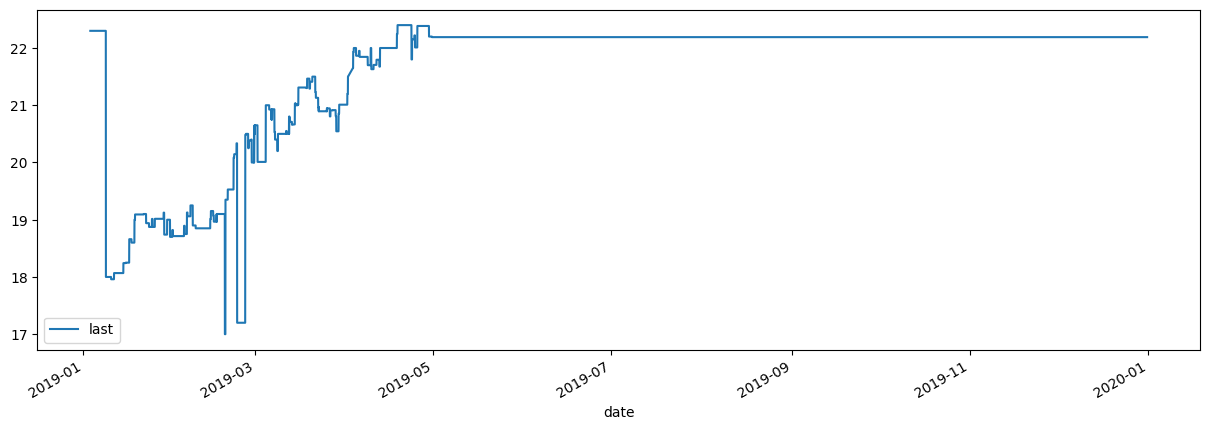

In [97]:
axa_1rPCSNV = axa[axa['symbol'] == '1rPCSNV']

axa_1rPCSNV.plot( y='last', figsize=(15, 5))
plt.show()

<Axes: xlabel='date'>

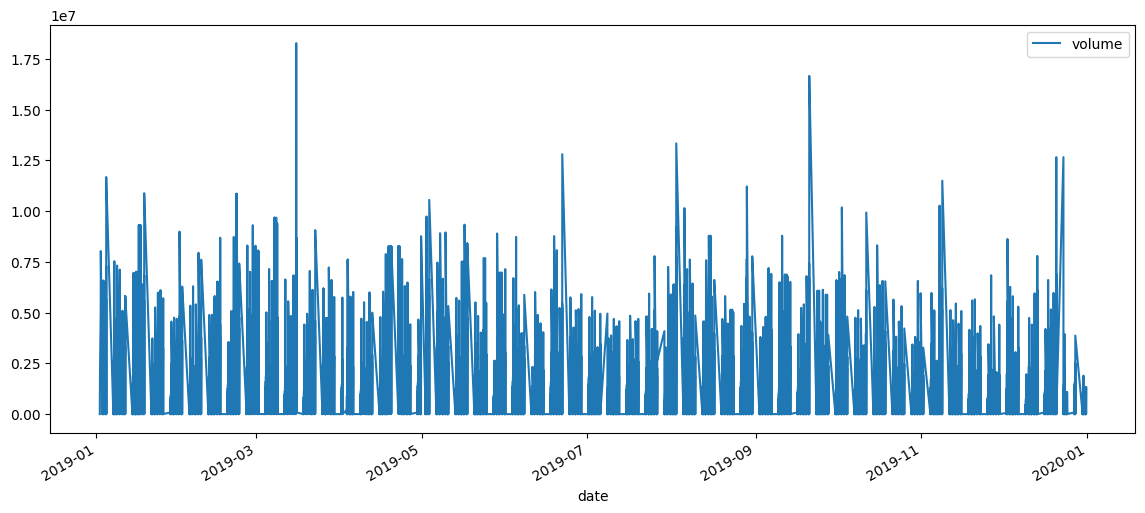

In [98]:
axa.plot(y="volume",figsize=(14, 6))

In [99]:
axa

,last,volume,symbol,name
date,,,,
2019-01-02 09:05:02.495959,18.858,0,1rPCS,AXA
2019-01-02 09:15:02.257640,18.554,376557,1rPCS,AXA
2019-01-02 09:25:02.791377,18.494,518948,1rPCS,AXA
2019-01-02 09:35:02.419187,18.482,754820,1rPCS,AXA
2019-01-02 09:45:02.823637,18.488,1086243,1rPCS,AXA
...,...,...,...,...
2019-12-31 17:32:01.678859,25.110,1311260,1rPCS,AXA
2019-12-31 17:42:01.814583,25.110,1311260,1rPCS,AXA
2019-12-31 17:42:01.814583,22.190,0,1rPCSNV,AXA


<Axes: xlabel='date'>

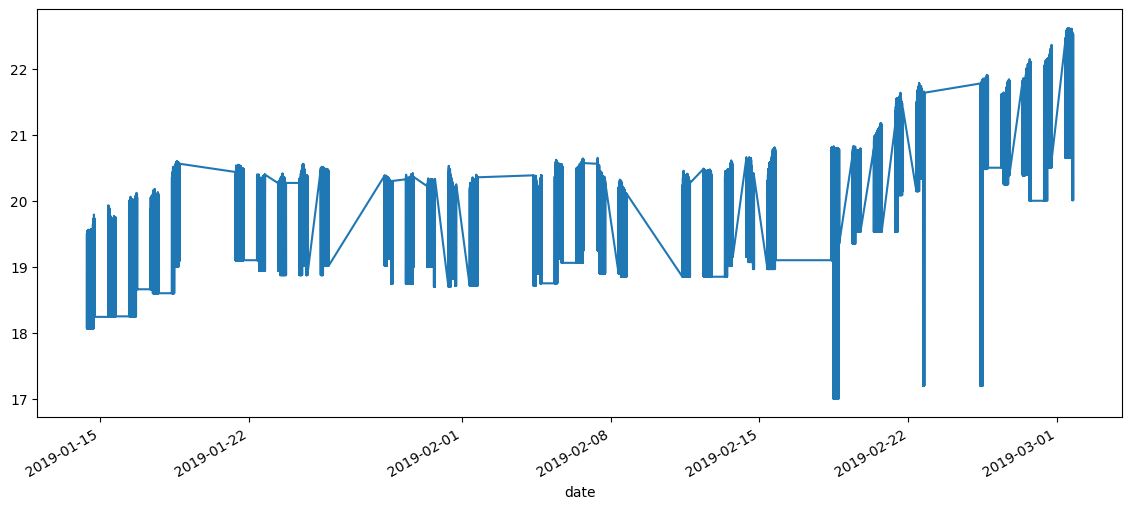

In [104]:
axa.loc["2019-01-12": "2019-03-01", "last"].plot(figsize=(14, 6))


<Axes: xlabel='date'>

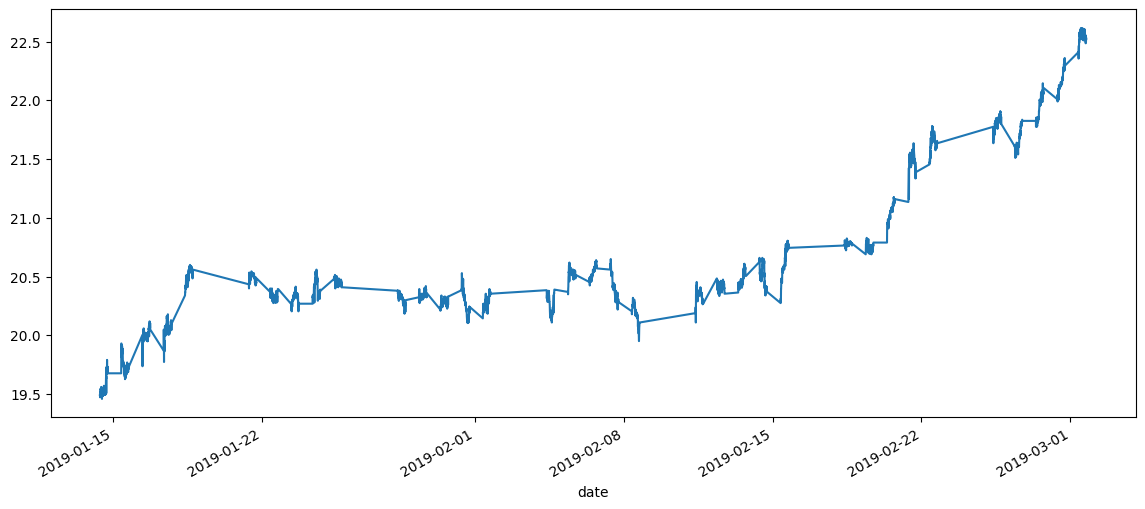

In [105]:
axa_1rPCS.loc["2019-01-12": "2019-03-01", "last"].plot(figsize=(14, 6))

<Axes: xlabel='date'>

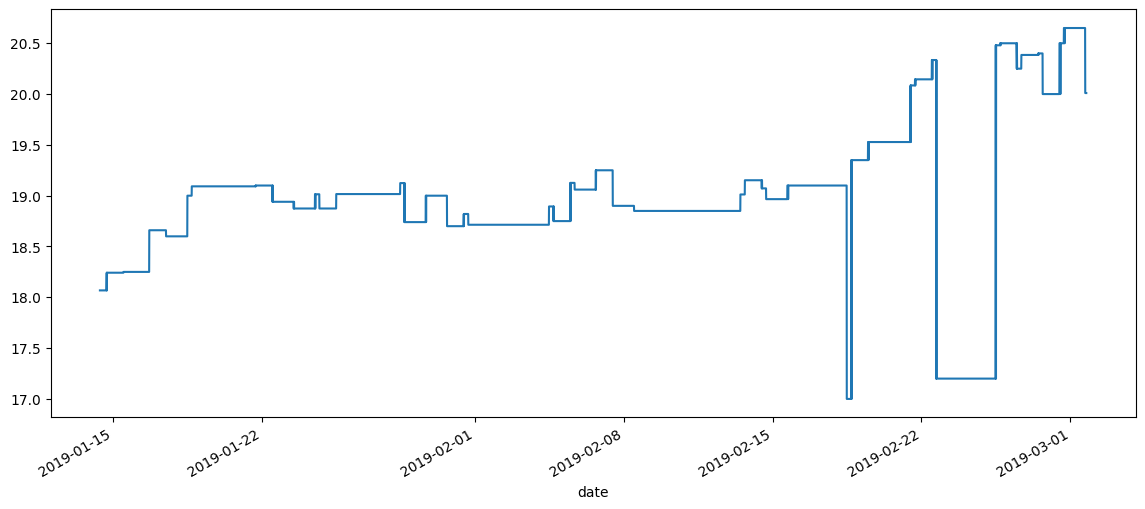

In [106]:
axa_1rPCSNV.loc["2019-01-12": "2019-03-01", "last"].plot(figsize=(14, 6))

<Axes: xlabel='last'>

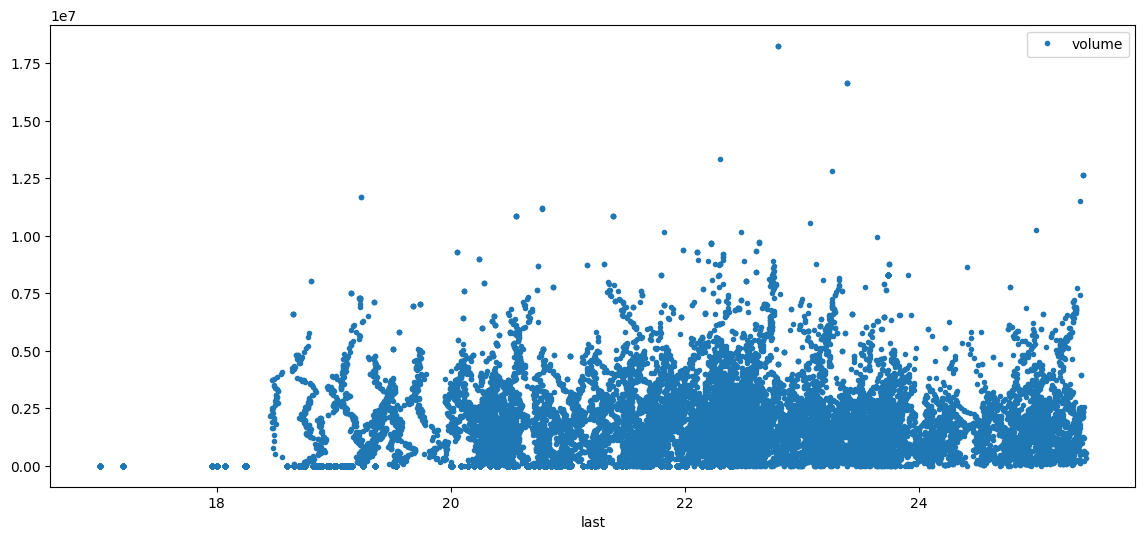

In [123]:

from matplotlib import pyplot as plt
axa.plot( x='last', y='volume', style= '.', figsize=(14, 6))